In [1]:
import numpy as np
import socket
import cv2
import matplotlib.pyplot as plt

## Install Stable Baseline3 version >= 2.0.0a5
#### Note some SB3 versions are not compatible with Gymnasium interface.

In [2]:
!pip install "stable-baselines3[extra] >= 2.0.0a5"

  Obtaining dependency information for stable-baselines3[extra]>=2.0.0a5 from https://files.pythonhosted.org/packages/1e/43/d4b83e644c7e42d90d76a1987fb98a2ab286a2b5593350210ca8efcc378e/stable_baselines3-2.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for gymnasium<0.30,>=0.28.1 from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/c8/c7/0d77e0e327bf09c12f445f92f5bad0b447375d7b836c5bac5255ead8436f/pygame-2.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for shimmy[atari]~=1.3.0 from https://files.pythonhosted.org/packages/dc/f9/07ef16463db14ac1b30f149c379760f5cacf3fc677b295d29a92f3127914/Shimmy-1.3.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 16.8 MB/s eta 0:00:00
  Installing bui

## Run the Java Tetris Server using subprocess

In [3]:
# You can download latest server from AIoTLab website. Currently (2023/12/5) is v0.6
# !wget http://www.aiotlab.org/teaching/oop/tetris/TetrisTCPserver_v0.6.jar
!cp /kaggle/input/112-1-ntut-dl-app-hw4/TetrisTCPserver_v0.6.jar .

In [4]:
import subprocess
subprocess.Popen(["java","-jar","TetrisTCPserver_v0.6.jar"])

<Popen: returncode: None args: ['java', '-jar', 'TetrisTCPserver_v0.6.jar']>

## Create our own Tetris Test environment by inheriting Gym class

In [5]:
import gymnasium as gym
from gymnasium import spaces

Tetris TCP server is listening at 10612


In [6]:
class TetrisEnv(gym.Env):
    
    metadata = {"render_modes": ["human"], "render_fps": 20}
    
    '''
        The supported actions are
        0: move -1
        1: move 1
        2: rotate 0 // counter-clockwise
        3: rotate 1 // clockwise
        4: drop down
    '''
    N_DISCRETE_ACTIONS = 5
    
    IMG_HEIGHT = 200
    IMG_WIDTH = 100
    IMG_CHANNELS = 3
    

    def __init__(self, host_ip="127.0.0.1", host_port=10612):
        super().__init__()
        
        self.action_space = spaces.Discrete(self.N_DISCRETE_ACTIONS)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
        self.server_ip = host_ip
        self.server_port = host_port
            
        self.client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.client_sock.connect((self.server_ip, self.server_port))

    def step(self, action):
        if action == 0:
            self.client_sock.sendall(b"move -1\n")
        elif action == 1:
            self.client_sock.sendall(b"move 1\n")
        elif action == 2:
            self.client_sock.sendall(b"rotate 0\n")
        elif action == 3:
            self.client_sock.sendall(b"rotate 1\n")
        elif action == 4:
            self.client_sock.sendall(b"drop\n")
            
        terminated, lines, height, holes, observation = self.get_tetris_server_response(self.client_sock)
        self.observation = observation
        
        reward = 0
        if action == 4: # Drop reward
            reward += 5
            
        # Negative height reward
        if height > self.height:
            reward -= (height - self.height)*5
        
        # Positive hole reduction reward
        if holes < self.holes:
            reward += (self.holes - holes)*20
        
        if lines > self.lines_removed:
            reward = reward + (lines - self.lines_removed)*1000
            self.lines_removed = lines
            
        self.reward = self.reward + reward
        self.holes = holes
        self.height = height
        truncated = False
        info = {}
        return (observation, reward, terminated, truncated, info)

    def reset(self, seed=None, options=None):
        self.client_sock.sendall(b"start\n")
        terminated, lines, height, holes, observation = self.get_tetris_server_response(self.client_sock)
        self.observation = observation
        self.reward = 0
        self.lines_removed = 0
        self.holes = 0
        self.height = 0
        info = {}
        return observation, info

    def render(self):
        ''''''
        #if self.render_mode == "console":
        #    print('Total reward ' + str(self.reward))
        '''
        if self.render_mode == "human":
            cv2.imshow("Image", self.observation)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        '''

    def close(self):
        self.client_sock.close()
        
    def get_tetris_server_response(self, sock):
        is_game_over = (sock.recv(1) == b'\x01')
        removed_lines = int.from_bytes(sock.recv(4), 'big')
        height = int.from_bytes(sock.recv(4), 'big')
        holes = int.from_bytes(sock.recv(4), 'big')
        img_size = int.from_bytes(sock.recv(4), 'big')
        img_png = sock.recv(img_size)

        nparr = np.frombuffer(img_png, np.uint8)
        np_image = cv2.imdecode(nparr, -1)

        return is_game_over, removed_lines, height, holes, np_image

## Use SB3 env_checker to check our environment

In [7]:
from stable_baselines3.common.env_checker import check_env

env = TetrisEnv()
# It will check your custom environment and output additional warnings if needed
# No response may be caused by mismatched action state definition and implementation
check_env(env)

Client has joined the game


## Randomly test the environment

In [8]:
obs, info = env.reset()
n_steps = 20
for _ in range(n_steps):
    # Random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    env.render() # We render nothing now
    
    if terminated:
        break

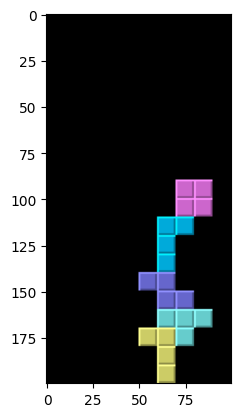

In [9]:
# Show the final screen
%matplotlib inline 
plt.imshow(obs)

In [10]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env

## Create an environment with 30 client threads

In [11]:
# Let's try A2C by creating 30 environments
vec_env = make_vec_env(TetrisEnv, n_envs=30)

Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game
Client has joined the game


## We choose A2C with CNN policy, and train 3,000,000 steps

In [12]:
# Train the agent
model = A2C("CnnPolicy", vec_env, verbose=1).learn(3000000)

Using cpu device
Wrapping the env in a VecTransposeImage.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 87.1     |
|    ep_rew_mean        | -76.4    |
| time/                 |          |
|    fps                | 168      |
|    iterations         | 100      |
|    time_elapsed       | 89       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -0.0354  |
|    explained_variance | 0.888    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0094  |
|    value_loss         | 27.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 116      |
|    ep_rew_mean        | -12.3    |
| time/                 |          |
|    fps                | 171      |
|    iterations         | 200      |
|    time_elapsed       | 175      |
|    total_timest

## Test our model with 1000 steps and record all plays.

In [13]:
import os
import shutil

# Test the trained agent
# using the vecenv
obs = vec_env.reset()
n_steps = 1000

replay_folder = './replay'
if os.path.exists(replay_folder):
    shutil.rmtree(replay_folder)

n_env = obs.shape[0] # Number of environments. A2C will play all envs
ep_id = np.zeros(n_env, int)
ep_steps = np.zeros(n_env, int)
cum_reward = np.zeros(n_env)
max_reward = -1e10
max_game_id = 0
max_ep_id = 0

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    
    if step % 10 == 0:
        print(f"Step {step}")
        print("Action: ", action)
        print("reward=", reward, "done=", done)
        
    for eID in range(n_env):
        cum_reward[eID] += reward[eID]
        folder = f'{replay_folder}/{eID}/{ep_id[eID]}'
        if not os.path.exists(folder):
            os.makedirs(folder)
        fname = folder + '/' + '{:06d}'.format(ep_steps[eID]) + '.png'
        cv2.imwrite(fname, obs[eID])
        #cv2.imshow("Image" + str(eID), obs[eID])
        #cv2.waitKey(10)
        ep_steps[eID] += 1
        
        if done[eID]:
            if cum_reward[eID] > max_reward:
                max_reward = cum_reward[eID]
                max_game_id = eID
                max_ep_id = ep_id[eID]
                
            ep_id[eID] += 1
            cum_reward[eID] = 0
            ep_steps[eID] = 0

#cv2.destroyAllWindows()

Step 0
Action:  [1 0 1 0 4 1 0 1 0 0 4 1 4 4 0 0 0 0 0 1 0 0 1 4 1 0 0 1 0 0]
reward= [  0.   0.   0.   0. -10.   0.   0.   0.   0.   0. -10.   0. -10. -10.
   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.
   0.   0.] done= [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Step 10
Action:  [1 4 0 0 1 0 4 0 1 0 0 0 0 0 0 0 1 4 4 0 4 4 0 0 4 0 0 1 4 1]
reward= [ 0.  5.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.
  5.  0. -5.  5.  0.  0.  5.  0.  0.  0.  5.  0.] done= [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Step 20
Action:  [0 4 4 0 4 1 4 4 0 4 1 4 4 0 1 0 4 4 1 1 0 1 0 4 0 4 0 4 4 1]
reward= [  0. -15.   0.   0.   5.   0.   5.   5.   0.  -5.   0.   5.   0.   0.
   0.   0.  

In [14]:
print("Goal reached!", " Max reward=", max_reward)
best_replay_path = f'{replay_folder}/{max_game_id}/{max_ep_id}'

Goal reached!  Max reward= 4210.0


## Make a gif image to visualize the best play

In [15]:
import glob
import imageio

filenames = sorted(glob.glob(best_replay_path + '/*.png'))

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('replay.gif', images, loop=0)

/tmp/ipykernel_19/3508690983.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


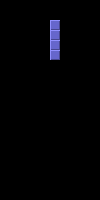

In [16]:
from IPython.display import Image
Image(filename='/kaggle/working/replay.gif')

In [17]:
model.save('your_studentID_a2c_30env_3M.zip')

In [18]:
with open('tetris_best_score.csv', 'w') as fs:
    fs.write('Id,Predicted\n')
    fs.write(f'game_score,{max_reward}\n')

In [19]:
# Upload your results to Kaggle
from IPython.display import FileLink
FileLink('tetris_best_score.csv')

/kaggle/working/tetris_best_score.csv